## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import keras as k
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from itertools import chain
import pydicom

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import tensorflow as tf

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
66852,00016521_005.png,Atelectasis|Consolidation|Mass|Nodule|Pneumoth...,5,16521,73,M,PA,2990,2991,0.143000,0.143000,NaN,/data/images_008/images/00016521_005.png
106326,00028631_000.png,Infiltration,0,28631,46,F,PA,1818,1710,0.194311,0.194311,NaN,/data/images_012/images/00028631_000.png
13314,00003459_032.png,Atelectasis,32,3459,52,F,AP,2500,2048,0.171000,0.171000,NaN,/data/images_002/images/00003459_032.png


In [4]:
all_xray_df.columns = ['image_index', 'finding_labels', 'follow_up', 'patient_id',
       'age', 'gender', 'view_position', 'width',  'height', 'pixel_x', 'pixel_y', 'unnamed', 'path']

In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
34828,00009190_001.png,No Finding,1,9190,61,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13956,00003602_000.png,No Finding,0,3602,42,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64655,00015956_028.png,Edema|Infiltration|Pneumonia,28,15956,69,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df["pneumonia_class"] = all_xray_df.Pneumonia.apply(lambda x: "yes" if x>0 else "no")

In [7]:
all_xray_df.loc[:, ["pneumonia_class", "Pneumonia"]]

,pneumonia_class,Pneumonia
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0
...,...,...
112115,yes,1.0
112116,no,0.0
112117,no,0.0
112118,no,0.0


## Create your training and testing data:

In [8]:
from sklearn.model_selection import train_test_split
from random import sample

def create_splits(df, target_name, test_size = 0.2, balance_train =  False, n_times_train = 1,  balance_test = False, n_times_test = 4):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = train_test_split(df, 
                                            test_size = test_size, 
                                            stratify = df[target_name]) 

    if balance_train:  
        p_inds = train_df[train_df[target_name] == 'yes'].index.tolist()
        np_inds = train_df[train_df[target_name] == 'no'].index.tolist()

        np_sample = sample(np_inds, n_times_train*len(p_inds))
        train_df = train_df.loc[p_inds + np_sample]
        
    if balance_test:
        p_inds = valid_df[valid_df[target_name] == 'yes'].index.tolist()
        np_inds = valid_df[valid_df[target_name] == 'no'].index.tolist()

        # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
        np_sample = sample(np_inds, n_times_test * len(p_inds))
        valid_df = valid_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

In [9]:
all_xray_df.pneumonia_class.value_counts()

no     110689
yes      1431
Name: pneumonia_class, dtype: int64

In [10]:
train, val_data = create_splits(all_xray_df, "pneumonia_class", 0.2, balance_train =  True, n_times_train = 3, balance_test = True, n_times_test = 5)

In [11]:
train.pneumonia_class.value_counts()

no     3435
yes    1145
Name: pneumonia_class, dtype: int64

In [12]:
val_data.pneumonia_class.value_counts()

no     1430
yes     286
Name: pneumonia_class, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation(train = True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    if train:
        idg = ImageDataGenerator(rescale = 1. / 255.0,
                                      horizontal_flip =  False, 
                                      vertical_flip = False , 
                                      height_shift_range = 0.05,
                                      width_shift_range = 0.05,
                                      rotation_range = 3, 
                                      shear_range = 0.9,
                                      zoom_range= 0.1
                                )
        
    else: 
        idg = ImageDataGenerator(rescale = 1. / 255.0)
    
    return idg

def make_train_gen(df, train_idg,  IMG_SIZE,  batch_size = 10):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = train_idg.flow_from_dataframe(dataframe = df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size
                                             )
    return train_gen


def make_val_gen(val_data, val_idg, IMG_SIZE, batch_size = 10):
    """
    
    
    """
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size
                                            ) 
    
   
    return val_gen

In [14]:
train.tail()

,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
90890,00022644_001.png,No Finding,1,22644,68,F,PA,2670,2573,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
107506,00029039_016.png,Infiltration|Pneumothorax,16,29039,61,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no
100063,00026516_003.png,No Finding,3,26516,47,F,PA,2722,2565,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
854,00000211_008.png,Cardiomegaly|Effusion,8,211,58,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
58242,00014398_031.png,Cardiomegaly|Effusion,31,14398,56,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no


In [15]:
train_dg = my_image_augmentation(train = True)
val_dg = my_image_augmentation(train = False)

train_gen = make_train_gen(train, train_dg, (224,224), batch_size = 16)
val_gen = make_val_gen(val_data, val_dg, (224,224), batch_size = 16)

Found 4580 validated image filenames belonging to 2 classes.
Found 1716 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
tX, tY = train_gen.next()

In [17]:
valX, valY = val_gen.next()

In [18]:
len(valX)

16

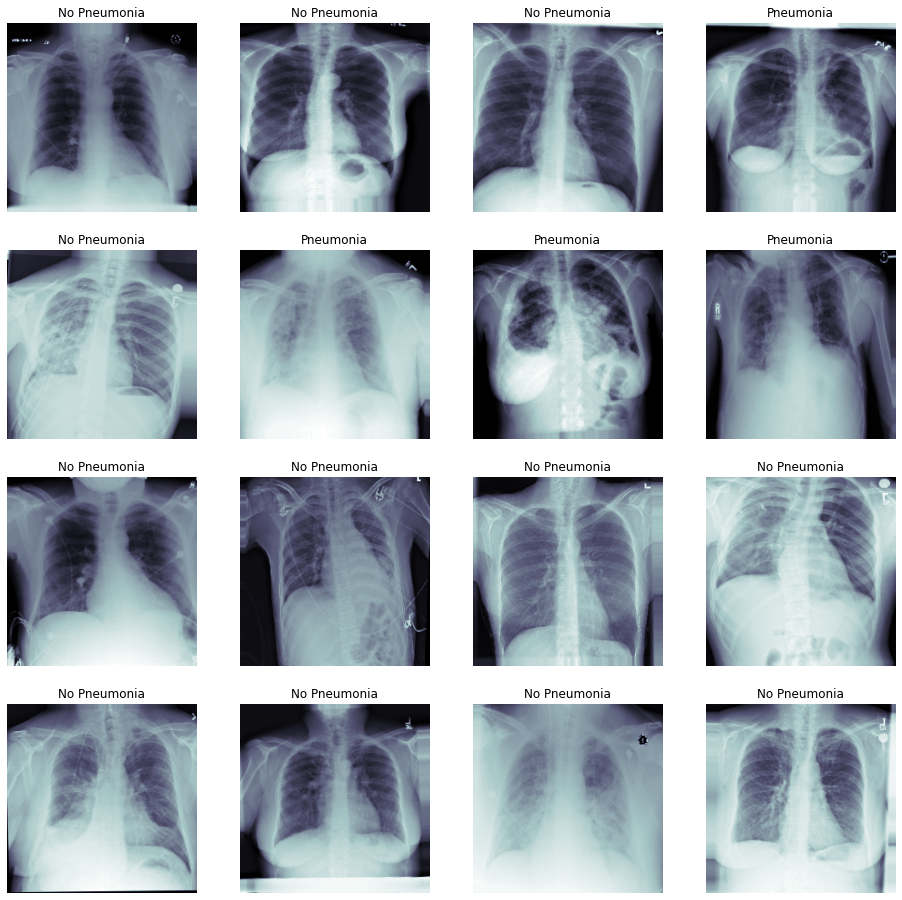

In [19]:
# t_x, t_y = next(gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(tX, tY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [20]:
def load_pretrained_model(lay_of_interest = 'block5_pool'):
    
    model = VGG16(include_top = True, weights = 'imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [18]:
IMG_HEIGHT = 224
IMG_WIDTH =  224

conv_base = ResNet50(weights ='imagenet',
                  include_top = False,
                  input_shape = (IMG_HEIGHT,IMG_WIDTH,3))

output = conv_base.layers[-1].output
output = k.layers.Flatten()(output)

# transfer_layer = conv_base.get_layer('pool1_pool')
resnet_model = Model(inputs = conv_base.input, outputs = output)

94773248/94765736 [==============================] - 2s 0us/step


In [19]:
# resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [21]:
def load_pretrained_model(lay_of_interest = 'block5_pool'):
    model = VGG16(include_top = True, weights = 'imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [22]:
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 8s 0us/step


In [23]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
def build_my_model(pretrained_model):
    
    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False  
        
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # Also make sure you set your optimizer, loss function, and metrics to monitor
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    
    #     model.add(Dense(512, activation='relu'))
    #     model.add(Dropout(0.2))
    #     model.add(Dense(512, activation='relu'))
    #     model.add(Dropout(0.2))
    #     model.add(Dense(1, activation='sigmoid')) 


    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))    
    
    model.add(Dense(256,  activation = 'relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1,  activation = 'sigmoid'))
    
    optimizer = Adam(lr = 0.001)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']    
    
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)    
    
    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class_vgg_v3')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = "val_loss", 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = "min", 
                             save_weights_only = True)

early = EarlyStopping(monitor = "val_loss", 
                      mode = "min", 
                      patience = 10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
# my_model = build_my_model(resnet_model)

In [27]:
my_model = build_my_model(vgg_model)

In [28]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
train_steps = train_gen.n//train_gen.batch_size
validation_steps = val_gen.n//val_gen.batch_size

print("Train steps per epoch",train_steps)
print("Val steps per epoch", validation_steps)

Train steps per epoch 286
Val steps per epoch 107


In [30]:
history = my_model.fit_generator(train_gen, steps_per_epoch = train_steps,
                          validation_data = (valX, valY), 
                          validation_steps = validation_steps,                       
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15
286/286 [==============================] - 127s 444ms/step - loss: 0.5886 - binary_accuracy: 0.7465 - val_loss: 0.4879 - val_binary_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.48789, saving model to xray_class_vgg_v3_my_model.best.hdf5
Epoch 2/15
286/286 [==============================] - 116s 405ms/step - loss: 0.5403 - binary_accuracy: 0.7493 - val_loss: 0.5149 - val_binary_accuracy: 0.8750

Epoch 00002: val_loss did not improve from 0.48789
Epoch 3/15
286/286 [==============================] - 115s 403ms/step - loss: 0.5354 - binary_accuracy: 0.7478 - val_loss: 0.5625 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss did not improve from 0.48789
Epoch 4/15
286/286 [==============================] - 117s 410ms/step - loss: 0.5268 - binary_accuracy: 0.7509 - val_loss: 0.5084 - val_binary_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.48789
Epoch 5/15
286/286 [==============================] - 119s 415ms/step - loss: 0.5169 - binary_accu

In [35]:
history = my_model.history

In [67]:
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [90]:
history

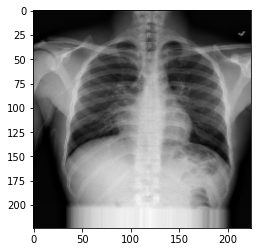

In [33]:
import matplotlib.pyplot as plt

plt.imshow(tX[0])
plt.show()

In [34]:
activations = activation_model.predict(tX)
# print(activations)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [33]:
test_gen = make_val_gen(val_data, val_dg, (224, 224), batch_size = 1400)

Found 1716 validated image filenames belonging to 2 classes.


In [34]:
testX, testY = test_gen.next()

In [35]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
# ## so there is no need to make the model perfect.
# my_model.load_weights(weight_path)

pred_Y = my_model.predict(testX,  verbose = True)

1400/1400 [==============================] - 18s 13ms/step


In [36]:
def plot_auc(t_y, p_y):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    ns_fpr, ns_tpr, _ = roc_curve(t_y, p_y)
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives rate")
    plt.legend(loc = "lower left")
    


def plot_precision_recall(t_y, p_y):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    precision_val, recall_val, _ = precision_recall_curve(t_y, p_y)
    plt.plot(recall_val, precision_val, linestyle='--')
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives rate")
    plt.legend(loc = "lower left")    

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    
    plt.figure()
    
    plt.plot(np.arange(0, N), history.history["loss"], label = "train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label = "val_loss")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc = "lower left")

No handles with labels found to put in legend.


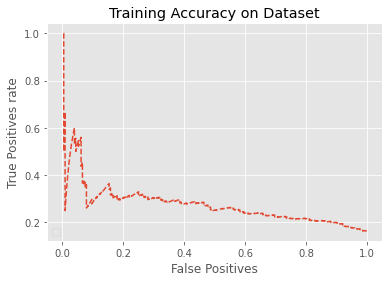

In [37]:
plot_precision_recall(testY, pred_Y)

No handles with labels found to put in legend.


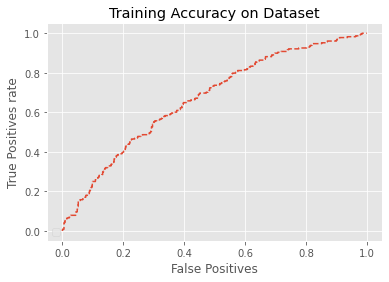

In [38]:
plot_auc(testY, pred_Y)

In [39]:
roc_auc_score(testY, pred_Y)

0.6677332195676905

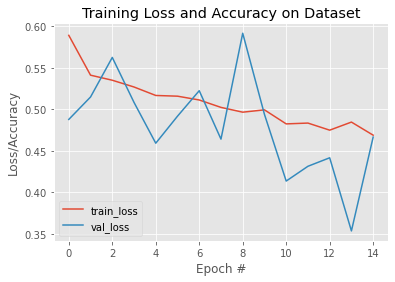

In [40]:
history = my_model.history
plot_history(history)

In [41]:
def binarize(pred_y, threshold):
    vector_integer = np.where(pred_y>threshold, 1, 0)
    return vector_integer

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [42]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(testY.astype(int), pred_Y)
f1_scores = []

for i in thresholds:
    f1 = f1_score(testY.astype(int), binarize(pred_Y, i))
    f1_scores.append(f1)

In [43]:
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

0.3141171

In [52]:
pred_binary = np.where(pred_Y>=best_threshold, 1, 0)

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.float_format', lambda x: '%.5f' % x)

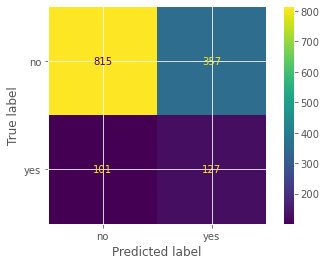

In [73]:
cm = confusion_matrix(testY , pred_binary)
ConfusionMatrixDisplay(cm, display_labels = ["no", "yes"]).plot(values_format='');

In [88]:
# f1_scores

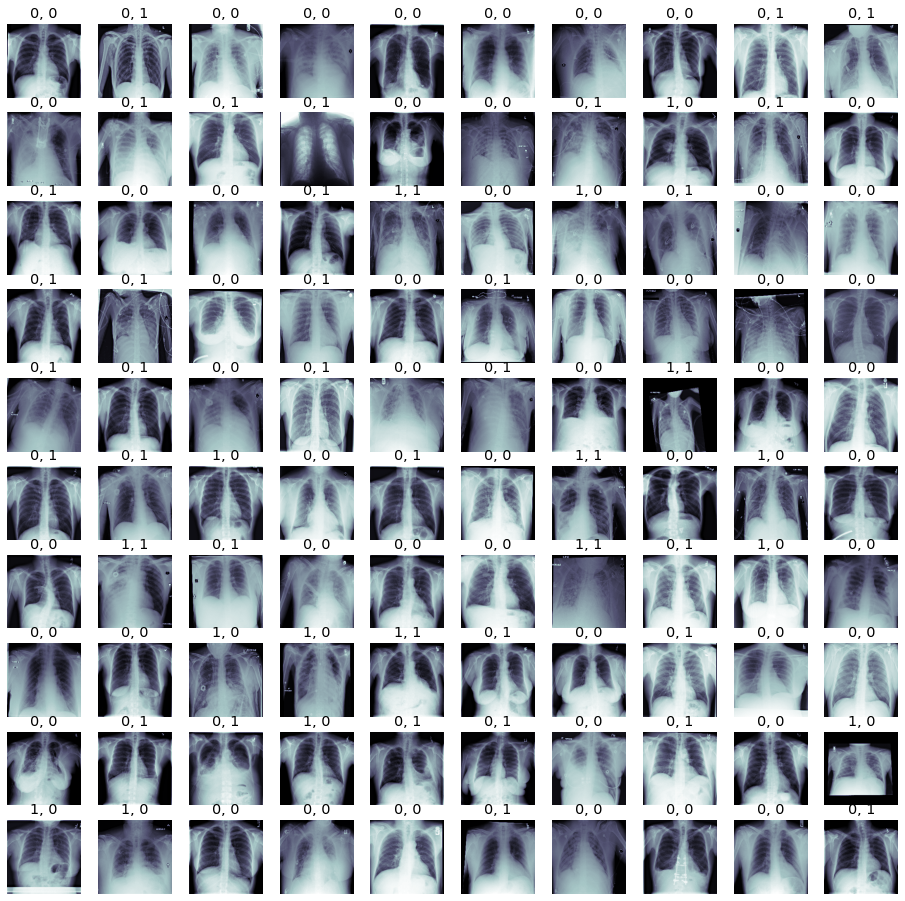

In [90]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[500:600], testY[500:600], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i][0] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i][0] > best_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    
    i=i+1

In [91]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)